In [1]:
import sys 
import os
sys.path.append(os.path.abspath("/Users/13793/Desktop"))

In [2]:
import ND_north_star.src.noise_generators.perlin_noise_generator as PNG

import ND_north_star.src.edge_detection.complex as ED_com
import ND_north_star.src.edge_detection.gradient_detection as ED_sim


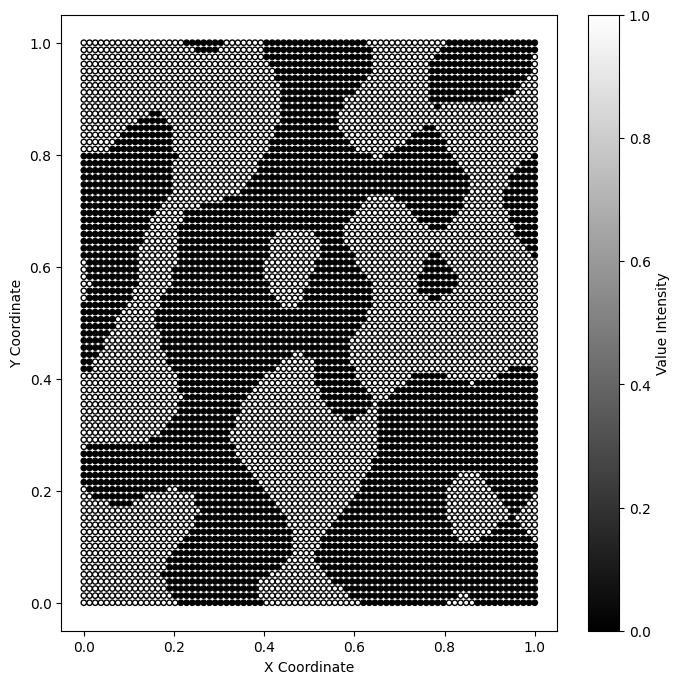

In [2]:
resolution = 80
dimensions = [resolution, resolution]


dataset = PNG.normalized_perlin_data(dimensions, 5)

# Plot perlin noise coord in x and y coordinates and with intensity values surrounded by a black outline
PNG.plot_perlin_2D_3D(dataset, 'black')

In [3]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

def identify_boundary_points(data, labels, n_neighbors=5):
    boundary_points = []
    for idx, point in enumerate(data):
        if labels[idx] == 1:
            neighbors = NearestNeighbors(n_neighbors=n_neighbors).fit(data).kneighbors([point], return_distance=False)
            if any(labels[neighbor] == 0 for neighbor in neighbors[0]):
                boundary_points.append(point)
    return np.array(boundary_points)

# Example usage
data = dataset['features']  # Your N-dimensional data points
labels = dataset['values']  # Your corresponding labels (1 or 0)
boundary_points = identify_boundary_points(data, labels, 5)


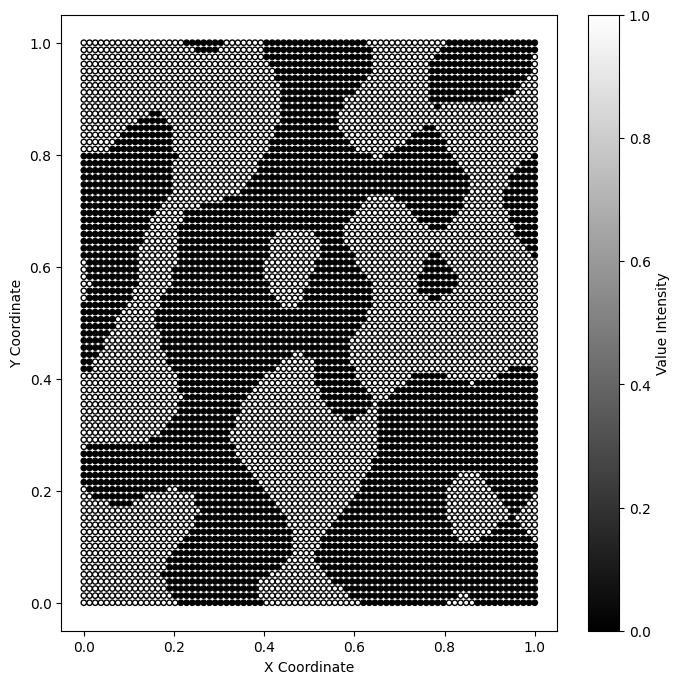

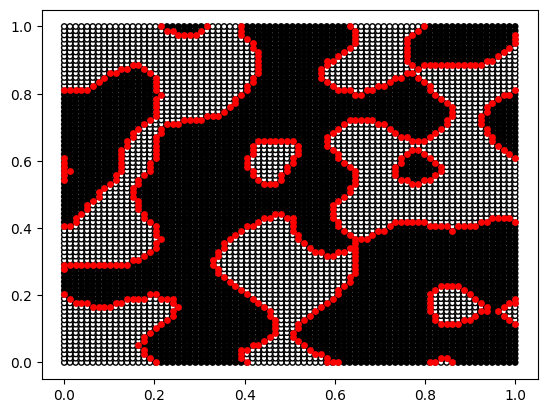

In [4]:
import numpy as np
import matplotlib.pyplot as plt

PNG.plot_perlin_2D_3D(dataset, 'black')

data = np.array(data)

if resolution < 100:
    marker_scale = resolution
else:
    marker_scale = 4*resolution

# Scatter plot
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='gray', s=1200/marker_scale, edgecolors='black')
plt.scatter(boundary_points[:, 0], boundary_points[:, 1], c='red', s=1200/marker_scale)

plt.show()


In [5]:
print(boundary_points)

[[0.         0.20253165]
 [0.         0.27848101]
 [0.         0.29113924]
 ...
 [1.         0.94936709]
 [1.         0.96202532]
 [1.         0.97468354]]


C:\Users\joesc\AppData\Local\Temp\ipykernel_12576\1687577328.py:41: RuntimeWarning: divide by zero encountered in scalar divide
  circum_r = a * b * c / (4.0 * area)
C:\Users\joesc\AppData\Local\Temp\ipykernel_12576\1687577328.py:40: RuntimeWarning: invalid value encountered in sqrt
  area = np.sqrt(s * (s - a) * (s - b) * (s - c))


[[array([[0.41772152, 0.84810127],
       [0.41772152, 0.83544304]]), array([[0.41772152, 0.83544304],
       [0.43037975, 0.86075949]]), array([[0.43037975, 0.86075949],
       [0.41772152, 0.84810127]]), array([[0.16455696, 0.30379747],
       [0.15189873, 0.30379747]]), array([[0.15189873, 0.30379747],
       [0.13924051, 0.29113924]]), array([[0.13924051, 0.29113924],
       [0.16455696, 0.30379747]]), array([[0.43037975, 0.87341772],
       [0.41772152, 0.84810127]]), array([[0.43037975, 0.86075949],
       [0.43037975, 0.87341772]]), array([[0.43037975, 0.87341772],
       [0.43037975, 0.88607595]]), array([[0.43037975, 0.88607595],
       [0.41772152, 0.84810127]]), array([[0.17721519, 0.3164557 ],
       [0.15189873, 0.30379747]]), array([[0.16455696, 0.30379747],
       [0.17721519, 0.3164557 ]]), array([[0.15189873, 0.30379747],
       [0.12658228, 0.29113924]]), array([[0.12658228, 0.29113924],
       [0.13924051, 0.29113924]]), array([[0.17721519, 0.87341772],
       [0.139

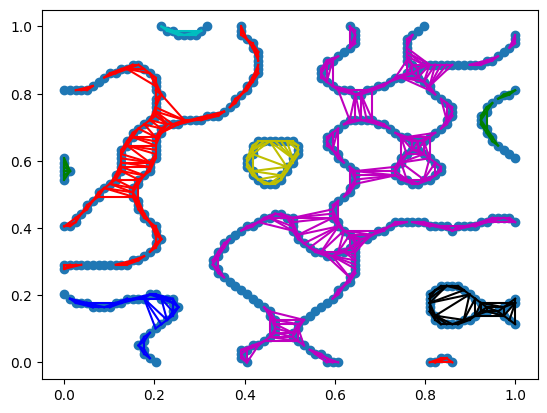

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from scipy.spatial import Delaunay

def alpha_shape(points, alpha):
    if len(points) < 4:
        # When there are less than 4 points, the boundary is the convex hull.
        return Delaunay(points).convex_hull

    def add_edge(edges, edge_points, coords, i, j):
        """
        Add a line between the i-th and j-th points, if not in the list already.
        """
        if (i, j) in edges or (j, i) in edges:
            # already added
            return
        edges.add((i, j))
        edge_points.append(coords[[i, j]])

    coords = np.array(points)
    tri = Delaunay(coords)
    edges = set()
    edge_points = []

    # Loop over triangles:
    # ia, ib, ic are indices of corner points of the triangle.
    for ia, ib, ic in tri.simplices:
        pa = coords[ia]
        pb = coords[ib]
        pc = coords[ic]

        # Compute lengths of sides of triangle
        a = np.linalg.norm(pa - pb)
        b = np.linalg.norm(pb - pc)
        c = np.linalg.norm(pc - pa)

        # Compute circumradius
        s = (a + b + c) / 2.0
        area = np.sqrt(s * (s - a) * (s - b) * (s - c))
        circum_r = a * b * c / (4.0 * area)

        if circum_r < alpha:
            add_edge(edges, edge_points, coords, ia, ib)
            add_edge(edges, edge_points, coords, ib, ic)
            add_edge(edges, edge_points, coords, ic, ia)

    return edge_points

def find_boundaries(points, alpha, eps=0.05, min_samples=5):
    # Cluster the points using DBSCAN
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(points)
    labels = clustering.labels_

    # Find unique clusters
    unique_labels = set(labels)
    boundaries = []

    for label in unique_labels:
        if label == -1:
            # Noise points, ignored in this context
            continue
        cluster_points = points[labels == label]
        boundary_edges = alpha_shape(cluster_points, alpha)
        boundaries.append(boundary_edges)

    return boundaries


alpha = 0.05  # This parameter needs to be tuned
boundaries = find_boundaries(boundary_points, alpha)

print(boundaries)

# Plot the points and the boundaries
plt.figure()
plt.plot(boundary_points[:, 0], boundary_points[:, 1], 'o')
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
for i, boundary_edges in enumerate(boundaries):
    color = colors[i % len(colors)]
    for edge in boundary_edges:
        plt.plot(edge[:, 0], edge[:, 1], color+'-')
plt.show()


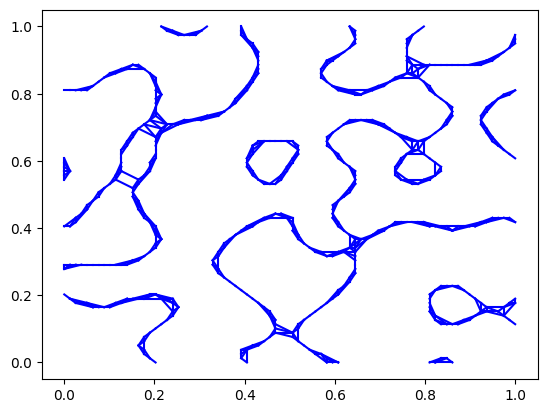

In [7]:
import numpy as np
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt

def alpha_shape(points, alpha):
    """
    Compute the alpha shape (concave hull) of a set of points.
    """
    if len(points) < 4:
        # In 3D, a tetrahedron is the smallest possible convex hull
        return Delaunay(points)

    def add_edge(edges, edge_points, coords, i, j):
        """
        Add an edge between the i-th and j-th points if not in the list.
        """
        if (i, j) in edges or (j, i) in edges:
            # Already added
            return
        edges.add((i, j))
        edge_points.append(coords[[i, j]])

    coords = np.array(points)
    tri = Delaunay(coords)
    edges = set()
    edge_points = []

    # Loop over simplices:
    for simplex in tri.simplices:
        for i in range(len(simplex)):
            for j in range(i + 1, len(simplex)):
                ia, ib = simplex[i], simplex[j]
                pa, pb = coords[ia], coords[ib]

                # Compute the length of the edge
                edge_length = np.linalg.norm(pa - pb)

                # Only add edge if its length is less than 1/alpha
                if edge_length < 1.0 / alpha:
                    add_edge(edges, edge_points, coords, ia, ib)

    return edge_points

# Example usage with sparse data points
points = boundary_points  # 100 sparse points in 2D
alpha = 20.0
edges = alpha_shape(points, alpha)

# Plot the alpha shape
for edge in edges:
    plt.plot(edge[:, 0], edge[:, 1], 'b-')
# plt.plot(points[:, 0], points[:, 1], 'ro')
plt.show()


{0, 1, 2, 3}


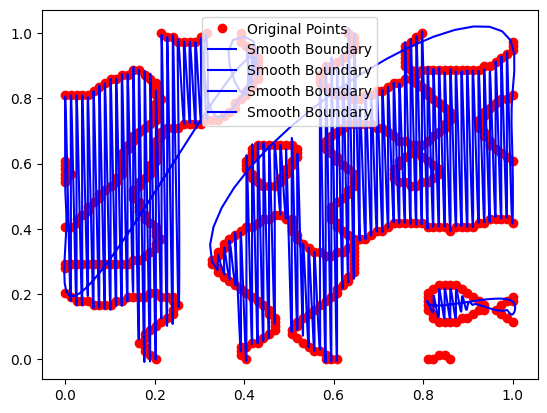

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev
from sklearn.cluster import DBSCAN

def smooth_boundary(points, eps=0.1, min_samples=5, smoothing_factor=0):
    """
    Compute a smooth boundary using cubic spline interpolation, ignoring points that are far away.
    """
    # Use DBSCAN to find clusters of points
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(points)
    labels = db.labels_

    
    # Get unique clusters
    unique_labels = set(labels)

    print(unique_labels)
    
    smooth_points_list = []
    for k in unique_labels:
        if k == -1:
            continue  # Ignore noise points
        class_member_mask = (labels == k)
        cluster_points = points[class_member_mask]
        
        # Append the first point to the end to close the loop
        cluster_points = np.concatenate([cluster_points, cluster_points[:1]])
        
        # Parameterize the points
        tck, u = splprep(cluster_points.T, s=smoothing_factor, per=True)
        
        # Generate a smooth set of points
        u_fine = np.linspace(0, 1, 1000)
        smooth_points = splev(u_fine, tck)
        
        smooth_points_list.append(np.array(smooth_points).T)
    
    return smooth_points_list

# Example usage with random points forming a rough circular shape
np.random.seed(0)
points = boundary_points

smooth_points_list = smooth_boundary(points, eps=0.1, min_samples=2, smoothing_factor=0.01)

# Plot the original points and smooth boundaries
plt.plot(points[:, 0], points[:, 1], 'ro', label='Original Points')
for smooth_points in smooth_points_list:
    plt.plot(smooth_points[:, 0], smooth_points[:, 1], 'b-', label='Smooth Boundary')
plt.legend()
plt.show()
